In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
path = "Stream-of-Consciousness Fiction.txt"

In [3]:
with open(path , "r" , encoding='utf-8') as f:
    text = f.read()
print(text[ : 30])

The city breathed in neon sigh


In [4]:
chars = sorted(list(set("".join(text))))
len(chars) # voacb size

67

In [5]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] 
decode = lambda l: ''.join([itos[i] for i in l])

In [6]:
encode("ashish raj")

[39, 57, 46, 47, 57, 46, 1, 56, 39, 48]

In [7]:
decode([39, 57, 46, 47, 57, 46, 1, 56, 39, 48])

'ashish raj'

In [10]:
data = encode(text)
data = np.array(data)
n = int(0.9 * len(data))
train_data = data[ : n]
val_data = data[n : ]

In [31]:
context_length = 32

In [32]:
def get_batch(i , split):
    # ix = tf.random.uniform((1,) , minval = 0 , maxval = (len(data)-context_length))
    # ix = tf.cast(ix , dtype = tf.int32)
    # ix = ix.numpy()
    # xb = [data[i : i+context_length] for i in ix]
    # yb = [data[i+1 : i+context_length+1] for i in ix]
    if split == "train":
        xb = train_data[i : i+context_length] 
        yb = train_data[i+1 : i+context_length+1] 
    elif split == "val":
        xb = val_data[i : i+context_length] 
        yb = val_data[i+1 : i+context_length+1]
    return xb , yb

In [33]:
xb , yb = get_batch(190 , "val")
xb , yb

(array([52, 57,  1, 39, 50, 53, 52, 45,  1, 58, 46, 43,  1, 56, 53, 53, 44,
        58, 53, 54,  3, 57,  1, 43, 42, 45, 43,  6,  1, 58, 46, 43]),
 array([57,  1, 39, 50, 53, 52, 45,  1, 58, 46, 43,  1, 56, 53, 53, 44, 58,
        53, 54,  3, 57,  1, 43, 42, 45, 43,  6,  1, 58, 46, 43, 47]))

In [34]:
decode(xb) , decode(yb)

("ns along the rooftop's edge, the", "s along the rooftop's edge, thei")

In [35]:
num_batches = 10000
x_batches = []
y_batches = []

for i in range(num_batches):
    xb, yb = get_batch(i , "train")
    x_batches.append(xb)
    y_batches.append(yb)

x_var = tf.reshape(x_batches , (num_batches , -1))
y_var = tf.reshape(y_batches , (num_batches , -1))

In [36]:
x_var.shape

TensorShape([10000, 32])

In [37]:
x_var[:5] , y_var[:5]

(<tf.Tensor: shape=(5, 32), dtype=int32, numpy=
 array([[35, 46, 43,  1, 41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43,
         42,  1, 47, 52,  1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6],
        [46, 43,  1, 41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43, 42,
          1, 47, 52,  1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6,  1],
        [43,  1, 41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43, 42,  1,
         47, 52,  1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6,  1, 47],
        [ 1, 41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43, 42,  1, 47,
         52,  1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6,  1, 47, 58],
        [41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43, 42,  1, 47, 52,
          1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6,  1, 47, 58, 57]])>,
 <tf.Tensor: shape=(5, 32), dtype=int32, numpy=
 array([[46, 43,  1, 41, 47, 58, 63,  1, 40, 56, 43, 39, 58, 46, 43, 42,
          1, 47, 52,  1, 52, 43, 53, 52,  1, 57, 47, 45, 46, 57,  6,  1],
        [43,  1, 41

In [38]:
num_batches = 1500
x_batches = []
y_batches = []

for i in range(num_batches):
    xb, yb = get_batch(i , "val")
    x_batches.append(xb)
    y_batches.append(yb)

x_val = tf.reshape(x_batches , (num_batches , -1))
y_val = tf.reshape(y_batches , (num_batches , -1))

print(x_val.shape)

(1500, 32)


# Transformer

In [118]:
emb_dim = 128
context_length = 32 #T
batch_size = 16 #B
vocab_size = len(chars)
dk = 16
epochs = 500
dropout = 0.1
n_heads = 8
Nx = 3
lr = 0.005

In [119]:
initializer = tf.keras.initializers.GlorotUniform()

In [120]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [121]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00045)

In [122]:
token_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, emb_dim, input_shape=(context_length,))
])  # (B, T, emb_dim)

pos_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(context_length, emb_dim, input_shape=())
])  # (T, emb_dim)

In [123]:
WQ = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WK = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WV = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WO = [tf.Variable(initializer(shape=(n_heads * dk, emb_dim)), trainable=True) 
      for _ in range(Nx)]

```
WK: (6, 4, 64, 16)
     ↑  ↑   ↑   ↑
    Nx  h  emb  dk

```    


So in your ```transformer_block(x, block_id, ...)```, you need to index as:
```WK[block_id][head]```

In [124]:
tril = tf.Variable(tf.keras.ops.tril(tf.ones((context_length,context_length))) , trainable = False) #(T , T)
mask = (tril == 0)

ln1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
])
ln2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
])

In [125]:
ffwd = [tf.keras.Sequential([
        tf.keras.layers.Input(shape=(context_length , emb_dim)),
        tf.keras.layers.Dense(4 * emb_dim),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(emb_dim),
        tf.keras.layers.Dropout(dropout)
    ]) for _ in range(Nx)]

ln_block = [tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
]) for _ in range(Nx)]

lm_head = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.Dense(vocab_size),
    tf.keras.layers.ReLU(),
])

In [126]:
parameters = (token_emb.trainable_variables + pos_emb.trainable_variables +
             [w for block in WQ for w in block] +
             [w for block in WK for w in block] +
             [w for block in WV for w in block] +
             WO +
             [p for f in ffwd for p in f.trainable_variables] +
             lm_head.trainable_variables +
             [p for ln in ln_block for p in ln.trainable_variables] +
             ln1.trainable_variables + ln2.trainable_variables)

no_params = sum(tf.size(p).numpy() for p in parameters)
print("Total number of parameters:", no_params)

Total number of parameters: 614339


In [127]:
def transformer_block(x , enc ,  block_id ,  ln_block , ffwd):
    multi_attention_score = [] # multi head outputs
    for head in range(n_heads):
        # Single masked self attention implementation
        key = x @ WK[block_id][head] # (B , T , DK)
        query = x @ WQ[block_id][head]
        value = x @ WV[block_id][head]
        wei = query @ tf.transpose(key , perm=[0,2,1]) #(B , T , dk) @ (B , dk , T) --> (B , T , T)
        wei = wei / tf.math.sqrt(tf.cast(dk , tf.float32))
        wei = tf.where(mask , float('-inf') , wei)
        wei = tf.nn.softmax(wei , axis = -1)  #(B , T , T)
        wei = tf.keras.layers.Dropout(dropout)(wei)        
        out = wei @ value #(B , T , dk)
        multi_attention_score.append(out) # n_heads elements of shape (B, T, dk)
    concatenated = tf.concat(multi_attention_score , axis=-1) # -> (B, T, n_heads * dk)
    output = concatenated @ WO[block_id] # (B, T, n_heads * dk) * (n_heads * dk , emb_dim) --> (B , T , emb_dim)
    output = tf.keras.layers.Dropout(dropout)(output) #(B , T , emb_dim)
    # Residual connection and Feed Forward Connection
    attn_out = output + enc # residual after attention  #(B , T , emb_dim)
    x = ln_block[block_id](attn_out) # layer norm
    ffn_out = attn_out + ffwd[block_id](x) # residual after feed forward   #(B , T , emb_dim)
    return ffn_out #(B , T , emb_dim)

In [89]:
# lre = tf.linspace(-5, -1, 500)
# lrs = 10 ** lre
# lrs = lrs.numpy()

In [128]:
losses = []
for epoch in range(epochs):
    ix = tf.keras.random.randint(shape=(batch_size,) , minval=0 , maxval=x_var.shape[0])
    Xb , Yb = tf.gather(x_var , ix) , tf.gather(y_var , ix) # batch X(batch_size, context_length) , Y(batch_size, context_length)
    with tf.GradientTape() as tape:
        # Context and Position Encoding
        te = token_emb(Xb)  #(B , T , emb_dim)
        pe = pos_emb(tf.range(context_length))  #(T , emb_dim)
        enc = te + pe  #(B , T , emb_dim)

        x = ln1(enc) # layer norm

        ############# Nx number of TRANSFORMER BLOCKS #############
        
        for i in range(Nx):
            x = transformer_block(x , enc , i , ln_block , ffwd) # x gets updated at each block operation rather than collecting outputs from all blocks .
            
        ###########################################################    
        
        # Final Linear for logits
        x = ln2(x) # (B , T , emb_dim)
        logits = lm_head(x) # (B , T , vocab_size)
        
        # Loss calculation
        logits_flat = tf.reshape(logits, (-1, logits.shape[2]))  # (B*T, vocab_size)
        targets_flat = tf.reshape(Yb, (-1,))  # (B*T,)
        loss = loss_fn(targets_flat, logits_flat)
        loss = tf.reduce_mean(loss)

    grads = tape.gradient(loss , parameters)
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 25 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f}")

epoch=0, loss=4.5129
epoch=25, loss=3.4637
epoch=50, loss=3.2852
epoch=75, loss=3.2801
epoch=100, loss=3.3640
epoch=125, loss=3.2196
epoch=150, loss=3.0287
epoch=175, loss=3.1020
epoch=200, loss=2.9866
epoch=225, loss=3.0724
epoch=250, loss=2.9389
epoch=275, loss=3.0406
epoch=300, loss=3.0179
epoch=325, loss=2.9886
epoch=350, loss=2.9422
epoch=375, loss=2.8600
epoch=400, loss=3.0501
epoch=425, loss=3.1123
epoch=450, loss=3.0188
epoch=475, loss=2.9663


In [68]:
# losses = []

# for epoch in range(epochs):
#     ix = tf.keras.random.randint(shape = (batch_size,) , minval=0 , maxval=x_var.shape[0])
#     Xb, Yb = tf.gather(x_var , ix) , tf.gather(y_var , ix) # batch X(16, 4) , Y(16, 4)
#     with tf.GradientTape() as tape:
        
#         # Context and Position Encoding
#         tm = token_emb(Xb) #(B , T , emb_dim)
#         pm = pos_emb(tf.range(context_length)) #(T , emb_dim)
#         enc = tm+pm #(B , T , emb_dim)
        
#         x = ln1(enc)  # layer norm
        
# ################### SINGLE BLOCK OF TRANSFORMER ######################################################       
#         multi_attention_score = [] # multi head outputs
#         for i in range(n_heads):
#         # Single masked self attention implementation
#             # B , T , EMB = x.shape
#             key = x @ WK[i] #(B , T , dk)
#             query = x @ WQ[i]
#             value = x @ WV[i]
#             wei = query @ tf.transpose(key , perm = [0 , 2 , 1]) #(B , T , dk) @ (B , dk , T) --> (B , T , T)
#             wei = wei / (dk ** 0.5)
#             wei = tf.where(mask , float('-inf') , wei)
#             wei = tf.nn.softmax(wei , axis = -1) #(B , T , T)
#             wei = tf.keras.layers.Dropout(dropout)(wei)
#             out = wei @ value #(B , T , dk)
#             multi_attention_score.append(out) # n_heads elements of shape (B, T, dk)
#         concatenated = tf.concat(multi_attention_score, axis=-1)  # -> (B, T, n_heads * dk)
#         output = concatenated @ WO # (B, T, n_heads * dk) * (n_heads * dk , emb_dim) --> (B , T , emb_dim)
#         output = tf.keras.layers.Dropout(dropout)(output)  #(B , T , emb_dim)

#         # Residual connection and Feed Forward Connection
#         attn_out = enc + output            # residual after attention  #(B , T , emb_dim)
#         x = ln2(attn_out)                  # layer norm
#         ffn_out = attn_out + ffwd(x)       # residual after FFN            (B , T , emb_dim)
# ######################################################################################################
   
#         # Final Linear for logits
#         x = ln3(ffn_out)
#         logits = lm_head(x) # (B , T , vocab_size)

#         # Loss calculation
#         logits_flat = tf.reshape(logits, (-1, logits.shape[2]))  # (B*T, vocab_size)
#         targets_flat = tf.reshape(Yb, (-1,))  # (B*T,)
#         loss = loss_fn(targets_flat, logits_flat)
#         loss = tf.reduce_mean(loss)

#     grads = tape.gradient(loss , parameters)
#     optimizer.apply_gradients(zip(grads, parameters))

#     losses.append(loss.numpy())

#     if epoch % 25 == 0:
#       print(f"epoch={epoch}, loss={loss.numpy():.4f}")

In [129]:
losses[-1]

2.8661022

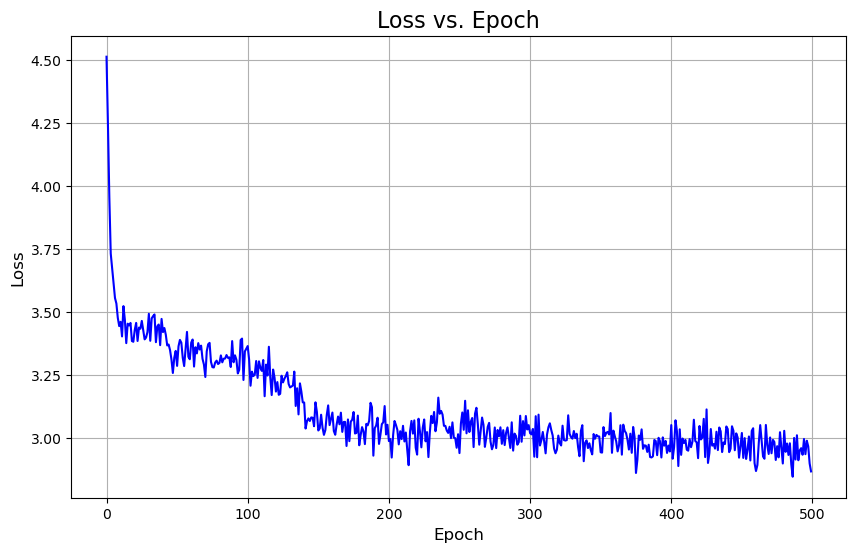

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(losses, linestyle='-', color='b')
plt.title('Loss vs. Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

In [131]:
generated = []
context = [0] * context_length  # Start context

for _ in range(350):  # Generate 350 tokens
    Xb = tf.constant([context], dtype=tf.int32)  # Shape (1, T)

    # Forward pass
    tm = token_emb(Xb)                          # (1, T, emb_dim)
    pm = pos_emb(tf.range(context_length))      # (T, emb_dim)
    pm = tf.expand_dims(pm, axis=0)             # (1, T, emb_dim)
    enc = tm + pm                               # (1, T, emb_dim)

    x = ln1(enc)
    for i in range(Nx):
        x = transformer_block(x , enc , i , ln_block , ffwd)
    x = ln2(x)
    logits = lm_head(x)                         # (1, T, vocab_size)

    # Take the logits at the last position
    last_logits = logits[:, -1, :]              # (1, vocab_size)
    probs = tf.nn.softmax(last_logits, axis=-1) # (1, vocab_size)

    ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
    context = context[1:] + [ix]  # Slide the context window
    generated.append(ix)


In [132]:
decode(generated)

'dySiei ersenleirllwsa h ablp sdudhaoryhNuiso pdidoshhwsenuverkntuegbeuyashnl8hennl shet i wlanrairhce ttlheefShhhMR hodgerya wnhech  Gercan iHlttl,o annf  fafdhsa icigi ethen ontt ddee  e, lonc,ts i hteerXad  ioa rhelenniyouaf,dh aglinansadc3 asorto  or ?tcoTb rhh tan   eneofhpos hghoadoe \'rhen4rp wtTltrheiil ang ciGiggasdwaeeupassestu" hyh yh,bpin'

### Conclusions
- *1 Block , 500 epochs , loss of = 2.3593497 , parameters = 58k , lr = 0.001 , context_length=4*
- **output sample:**'?WonDe yLenn sekive .\n?Iverueleals din reys itXinfene catwing c3whes yofeto frope ins thelAlkikin thous son owicho fXrol yYGthe noMvened thomam the chily eapaus The dliPy4 whif lling thea feo mivik whing eWr, imad chike ethis meYh fimingcA wher keingt liking fo icas tiwas ceund ’s 1h dintsD nowhr che carlits the thedn yos se0ler tc\ntaHeuld shcarad fi?’d indgn fon owrel siverfnallero any f yond yod the hameot doide i-hejabt
- *3 Block , 500 epochs , loss of = 2.6659708, parameters = 157955 , lr = 0.001 , context_length=4*
- **output sample:**'Sittift w thesd oa f1thung t" mm rtuh d Cfe theld a’deom shinderCun onthe 1cont serowhsoaltafban0 t D t lwin, cs s ig spiFn bino tme\'’boasapo’d3m sont, fa oqbe sthoen pintoberotifm the bpruler ds m thHatitolore\nphh fs f ofn d casrt Npegi m4lid, aLidipreralyctlar, lykoong apiSiclh rpin n s pty whiner y ) sso og o—tn ng ars y hikond w encand, on-nga s aalh pinopocerop wpaanong ,dd d,s oner ph cr Ritmis y a, slabon, d tliny\nndere r tichyrake s anrD l coff whithhe whenghaleoocs ung g, th s Cert ng\nDsend s theron yg e, thareppas whun cighondX-nenbb y tit oanfptoif
-  *2 Block , 500 epochs , loss of = 2.4319515, parameters = 91971 , lr = 0.001 , context_length=4*
-  'sin ly cag ha porire lomaa mabghesling laslolt amo 0eleude t sore ssshite borei, t0r dade ber tmanezasa t shy ’t bmeemit shayA serdicecYir dce neraome at pXses ans yuFwag t a on bad saimed aplGe teate uged t admed mat assed dad t sArt e me agkelof wMinea Gusfisitot s at aschir da at t fertry henslyootBun a in fealif reulpt?2g0rscarede hberis rens i'
-  *2 Block , 500 epochs , loss of = 2.5481987, parameters = 92227 , lr = 5e-4 , context_length=8*
-  'qnog an2 noitocC\ns cmintgiaves, lerass t\ndriIqn tade lonoot n clin cthalrant nthl mailillcen threre sicratg woprtilke s ghNnstheJEe—th the toltdef tan aneyl theranAtemclco satmo, fotinT’gaw thith he Theang pore arcantt cchFlin keivamestigint oyt toast whiIntor sthanbe const tocng thasngMiman thoviy "yot aln wheceang otskitele thof\'maetet vbecod ra '